In [38]:
#Importing the libraries that will be helpful during calculation
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

In [39]:
from torchvision import datasets
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()   # it converts PIL image into pytorch tensor and also normalise it
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()  # it converts PIL image into pytorch tensor and also normalise it
)

In [40]:
VALID_RATIO = 0.9

n_train_examples = int(len(training_data) * VALID_RATIO)
n_valid_examples = len(training_data) - n_train_examples
train_data, valid_data = torch.utils.data.random_split(training_data,
                                           [n_train_examples, n_valid_examples])

In [41]:
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator =torch.utils.data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator =torch.utils.data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

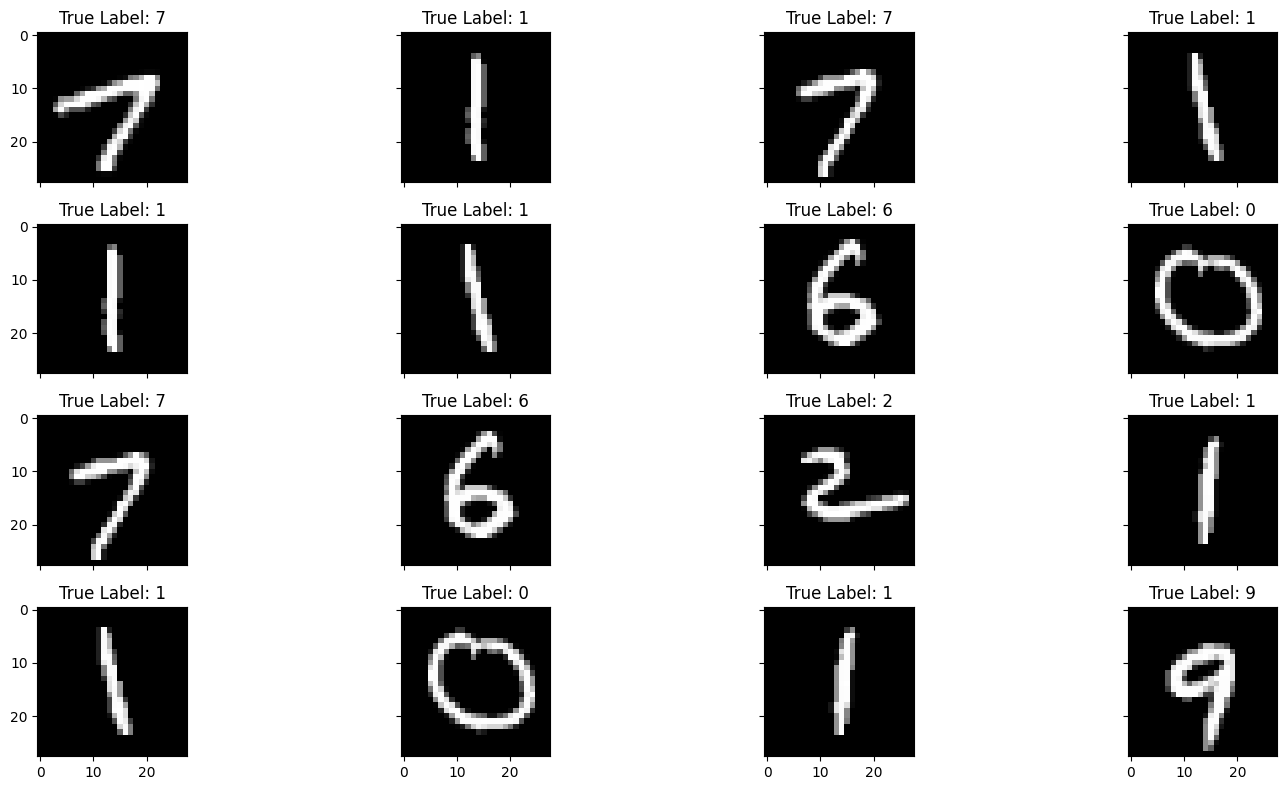

In [42]:
fig,ax= plt.subplots(nrows=4,ncols=4,figsize=(16,8),sharex=True,sharey=True)
for i in range(4):
  for j in range(4):
    k=(i+1)*(j+1)+100
    ax[i,j].imshow(training_data.data[k],cmap='gray')
    ax[i,j].set_title(f'True Label: {training_data.targets[k]}')
plt.tight_layout()

In [43]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = torch.nn.Linear(input_dim, 500)
        self.hidden1_fc = torch.nn.Linear(500, 250)
        self.hidden2_fc = torch.nn.Linear(250, 100)
        self.output_fc = torch.nn.Linear(100,output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        #x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = torch.nn.functional.relu(self.input_fc(x))

        # h_1 = [batch size, 500]

        h_2 = torch.nn.functional.relu(self.hidden1_fc(h_1))

        # h_2 = [batch size, 250]

        h_3 = torch.nn.functional.relu(self.hidden2_fc(h_2))

        # h_3 = [batch_size, 100]

        y_pred = self.output_fc(h_3)

        # y_pred = [batch size, output dim]

        return y_pred, h_3

In [44]:
model = MLP(784,10)

In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [46]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 543,860 trainable parameters


In [47]:
optimizer = torch.optim.Adam(model.parameters())

In [48]:
criterion = torch.nn.CrossEntropyLoss()

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
model = model.to(device)
criterion = criterion.to(device)

In [51]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [52]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for data in iterator:
        x=torch.flatten(data[0],start_dim=1)
        y=data[1]
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [53]:
for data in train_iterator:
  print(torch.flatten(data[0],start_dim=1).shape)
  break

torch.Size([64, 784])


In [54]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for data in iterator:
            x=torch.flatten(data[0],start_dim=1)
            y=data[1]
            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [55]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')




    print(f'Epoch: {epoch+1:02} ')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 
	Train Loss: 0.278 | Train Acc: 91.64%
	 Val. Loss: 0.143 |  Val. Acc: 95.43%
Epoch: 02 
	Train Loss: 0.102 | Train Acc: 96.92%
	 Val. Loss: 0.124 |  Val. Acc: 96.32%
Epoch: 03 
	Train Loss: 0.066 | Train Acc: 97.99%
	 Val. Loss: 0.079 |  Val. Acc: 97.68%
Epoch: 04 
	Train Loss: 0.048 | Train Acc: 98.43%
	 Val. Loss: 0.088 |  Val. Acc: 97.30%
Epoch: 05 
	Train Loss: 0.037 | Train Acc: 98.72%
	 Val. Loss: 0.095 |  Val. Acc: 97.17%
Epoch: 06 
	Train Loss: 0.032 | Train Acc: 98.91%
	 Val. Loss: 0.105 |  Val. Acc: 97.24%
Epoch: 07 
	Train Loss: 0.027 | Train Acc: 99.12%
	 Val. Loss: 0.087 |  Val. Acc: 97.78%
Epoch: 08 
	Train Loss: 0.020 | Train Acc: 99.39%
	 Val. Loss: 0.084 |  Val. Acc: 97.85%
Epoch: 09 
	Train Loss: 0.021 | Train Acc: 99.32%
	 Val. Loss: 0.096 |  Val. Acc: 97.64%
Epoch: 10 
	Train Loss: 0.019 | Train Acc: 99.36%
	 Val. Loss: 0.086 |  Val. Acc: 97.88%


In [56]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

In [57]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.078 | Test Acc: 97.62%


In [62]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for data in iterator:
            x=torch.flatten(data[0],start_dim=1)
            y=data[1]
            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = torch.nn.functional.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [59]:
from sklearn import metrics

In [60]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

In [63]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

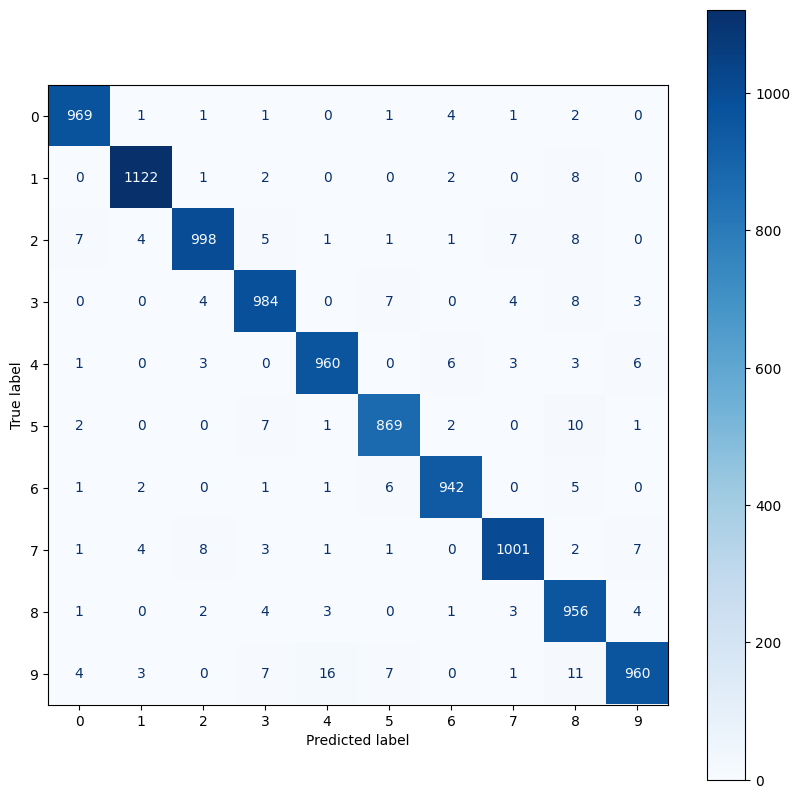

In [64]:
plot_confusion_matrix(labels, pred_labels)

In [65]:
corrects = torch.eq(labels, pred_labels)

In [66]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

In [67]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

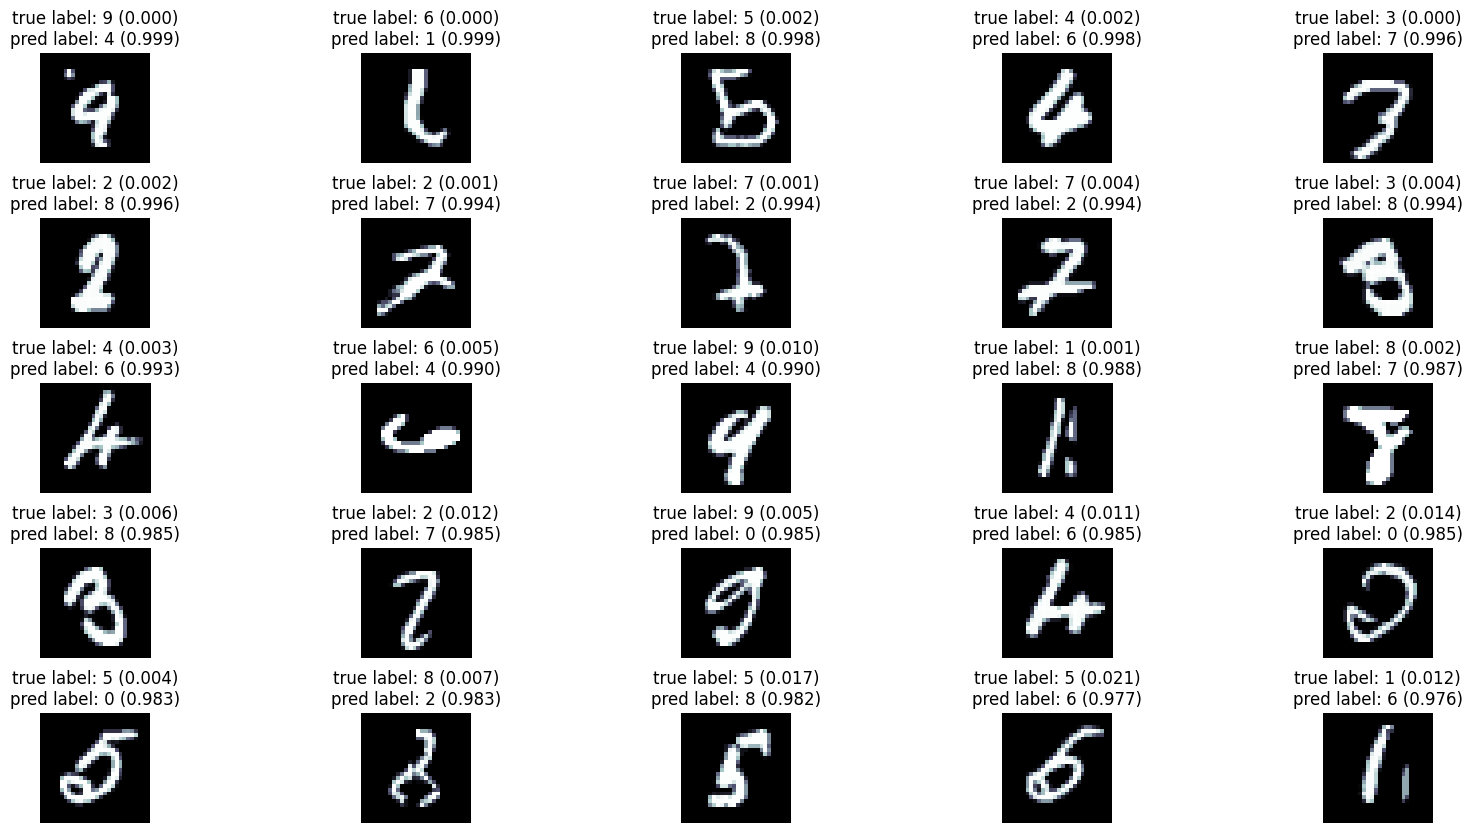

In [68]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [69]:
from sklearn import decomposition
from sklearn import manifold

In [73]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for data in iterator:
            x=torch.flatten(data[0],start_dim=1)
            y=data[1]
            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [70]:
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [71]:
def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

In [74]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

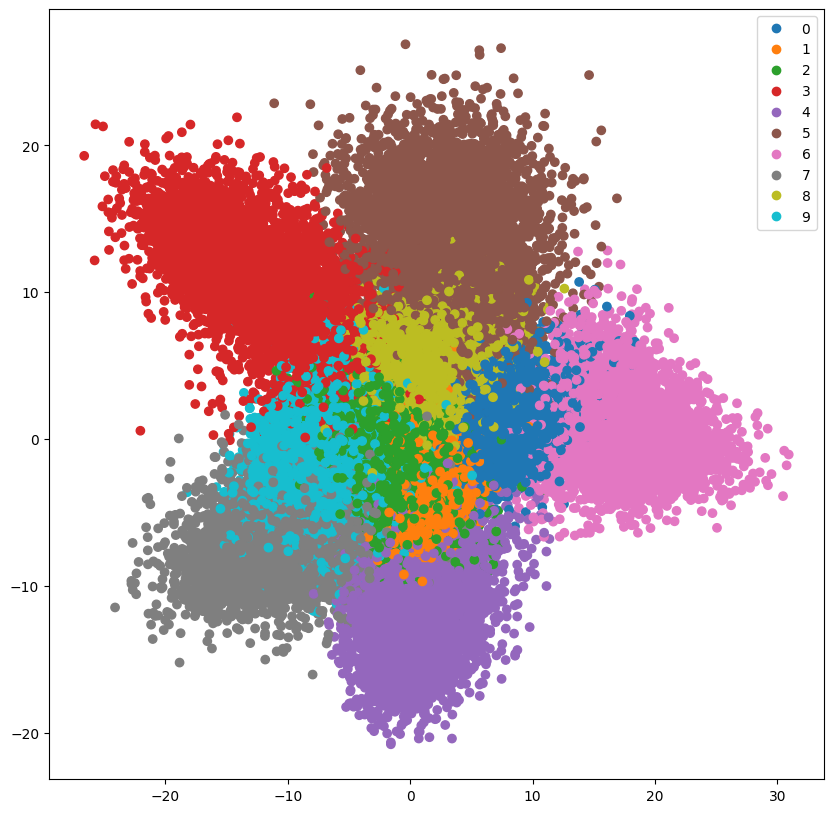

In [75]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

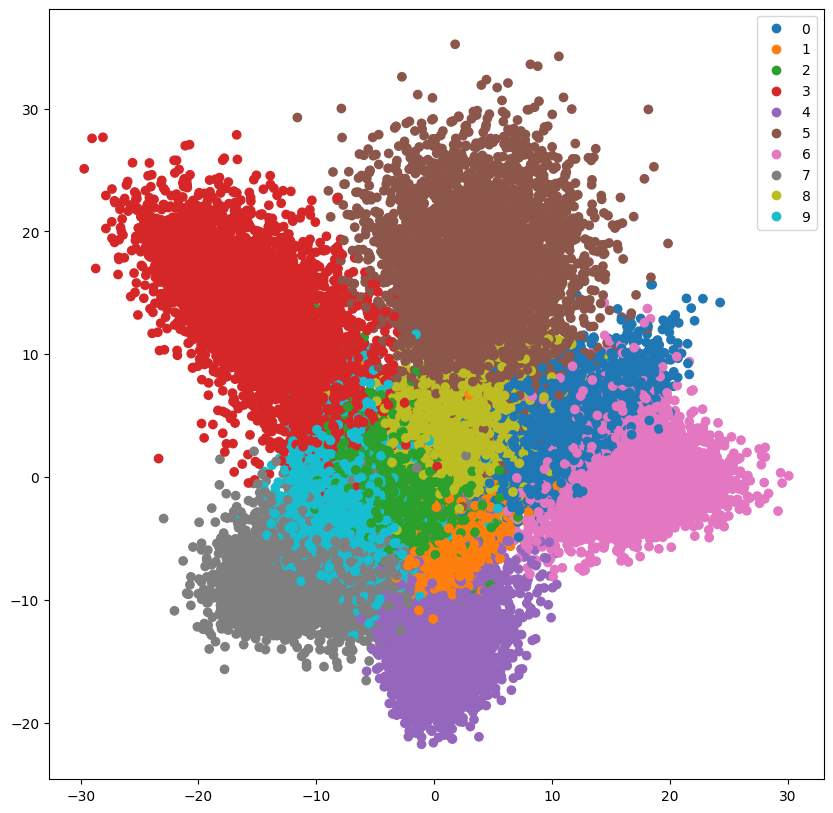

In [76]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)